In [61]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import chisqprob
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.fill_bounds import *

sns.set_style('ticks')

directories = json.load(open('directories.json'))

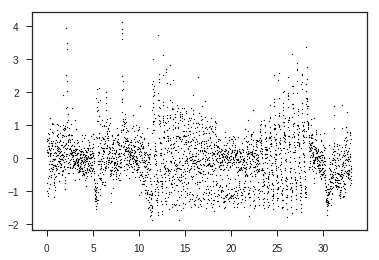

In [81]:
chirp_df = pd.read_csv(directories['data'] + 'SMP_M1_RR1_IPL6_LChirp.csv', index_col = 0)
chirp_df = chirp_df.groupby(['roi', 'frame']).mean().reset_index()

target_roi = 2
x = chirp_df.loc[chirp_df['roi'] == target_roi, 'x_t']
x_warp = chirp_df.loc[chirp_df['roi'] == target_roi, 'x_t_warped']
y = chirp_df.loc[chirp_df['roi'] == target_roi, 'y']

plt.scatter(x, y, color = 'k', s = 1)

In [82]:
m0 = GPy.models.SparseGPRegression(
    x_warp[:, None],
    y[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m0.optimize_restarts(4, max_iters = 25, messages = True)

x_predict = np.linspace(0, 33, 32 * 20)

iso_reg = IsotonicRegression()
iso_reg.fit(chirp_df['x_t'], chirp_df['x_t_warped'])
x_predict_warp = iso_reg.transform(x_predict)
chirp_mu, chirp_sig = m0.predict(x_predict_warp[:, None], include_likelihood = False)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    02s06  10   3.564715e+03   2.727892e+03 
    06s20  28   3.362049e+03   1.036337e+05 
Runtime:     06s20
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 3362.0491120059564
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s04  05   3.679722e+03   8.825097e+02 
    02s21  10   3.653468e+03   1.316944e+02 
    05s80  27   3.647861e+03   6.420399e+01 
Runtime:     05s80
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 3647.8606455570903
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s06  05   3.839224e+03   3.081098e+04 
    05s92  27   3.649769e+03   8.732664e+01 
Runtime:     05s92
Optimization status: Maximum number of f evaluations reached

Optimization restart 3/4, f = 3649.768980385944
Running L-BFGS-B (Scipy im

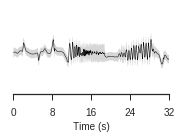

In [93]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(x_predict, chirp_mu, color = 'k', alpha = 1, linewidth = 0.5)
upper, lower = compute_bounds(chirp_mu, chirp_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
ax.set_ylim(-3, 3)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2.8, 1.5)

plt.savefig(directories['figs'] + 'active/' + 'chirp_ctrl.svg', dpi = 300)

In [27]:
off_sine_df = pd.read_csv(directories['data'] + 'SMP_M1_RR1_IPL6_SineControl.csv', index_col = 0)
off_sine_df = off_sine_df.groupby(['roi', 'frame']).mean().reset_index()

sine_conditions = pd.read_csv(directories['misc'] + 'sine_conditions_control.csv', header = None)
sine_conditions.columns = ["shape", "frequency", "contrast"]
sine_conditions['trial'] = np.arange(len(sine_conditions))
off_sine_df = sine_conditions.merge(off_sine_df)

target_roi = 1

In [28]:
n_trials = 90

off_sine_df = off_sine_df[off_sine_df['trial'] < n_trials]

In [29]:
stimulation_start = off_sine_df['t'].min()

roi_df = off_sine_df.loc[off_sine_df['roi'] == target_roi, :]

x = roi_df['t']
y = roi_df['y']

stimulus = []
temporal_freq = 50

for itx, row in sine_conditions.iterrows():
    if row['shape'] != 0:
        stimulus.append(np.sin(np.linspace(0, 2 * np.pi, temporal_freq) * row['frequency']) * row['contrast'])
    else:
        stimulus.append(np.ones(temporal_freq) * np.nan)
        
sine_stimulus = np.hstack(stimulus)
sine_stimulus /= np.nanmax(sine_stimulus)
sine_tpnts = np.linspace(0, len(sine_conditions), len(sine_conditions) * temporal_freq) + stimulation_start

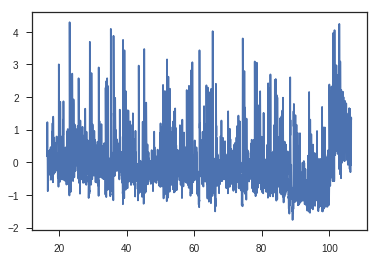

In [30]:
plt.plot(x, y)

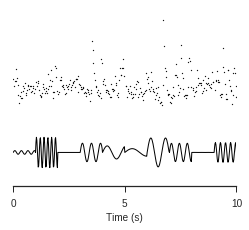

In [31]:
fig, ax = plt.subplots(1)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 1, color = 'k')

# ax.plot(x, y, linewidth = 0.5, color = 'k')
stimulus_delay = 0
ax.scatter(x - stimulus_delay, y, s = 1, color = 'k', marker = 'o')

start = stimulation_start
ax.set_xlim(start, start + 10)
ax.get_yaxis().set_visible(False)
plt.xticks([start, start + 5, start + 10])
ax.set_xticklabels([0, 5, 10])
sns.despine(left = True, ax = ax, offset = 10)
ax.set_xlabel('Time (s)', fontsize = 10);
plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(4, 3)

# plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mean_traces.png', **fig_p)

In [96]:
shape_bool = off_sine_df['shape'] == 1
roi_bool = off_sine_df['roi'] == target_roi
roi_df = off_sine_df.loc[shape_bool & roi_bool, :]

trial_duration = 1
roi_df['x_t'] = (roi_df['t'] - stimulus_delay) % trial_duration
roi_df['phase'] = (roi_df['x_t'] * 2 * np.pi * roi_df['frequency'])

x_cos = np.cos(roi_df['phase'].values)[:, None]
x_sin = np.sin(roi_df['phase'].values)[:, None]
x_frequency = roi_df['frequency'].values[:, None]
x_contrast = roi_df['contrast'].values[:, None]

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)
y = roi_df['y'][:, None]

 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [97]:
X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

y = roi_df['y'][:, None]

k1 = GPy.kern.RBF(4, ARD = False, active_dims = [0, 1, 2, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 2])

m1 = GPy.models.SparseGPRegression(
        X,
        y,
        num_inducing = 1000,
        kernel = k1
    )

%time m1.optimize_restarts(4, messages = True, max_iters = 25)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    09s51  02   3.232892e+03   2.967509e+05 
    42s00  09   2.713214e+03   1.031970e+03 
 01m52s03  27   2.663180e+03   8.882231e+00 
Runtime:  01m52s03
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 2663.1795819203035
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    14s54  04   4.830994e+03   6.752472e+05 
    40s51  11   3.205582e+03   1.180144e+03 
    47s63  13   3.181949e+03   3.143255e+02 
 01m30s37  26   3.171357e+03   2.324770e-04 
 01m33s14  27   3.171357e+03   2.324770e-04 
Runtime:  01m33s14
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 3171.357292711012
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    07s45  04   7.252845e+03   1.535067e+07 
    25s69  14   3.156406e+03   7.656489e+01 
    51s16  27   3.143

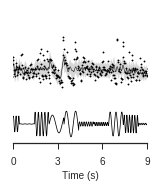

In [98]:
post_mu, post_sig = m1.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

x_t = roi_df['t']
ax.scatter(x_t, roi_df['y'], s = 2, color = 'k', marker = 'o')
ax.plot(x_t, post_mu, linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
plt.xlim(32, 41)
plt.xticks(np.arange(0, 12, 3) + 32)
ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(2.4, 2.4)

plt.savefig(directories['figs'] + 'active/' + 'Control Data.svg', dpi = 600)

In [35]:
n_tpnts = 256
freq_tpnts = np.linspace(0, 8, n_tpnts) + 10
x_new_frequency = ((np.pi * np.linspace(0, 8, n_tpnts) ** 2) % (2 * np.pi))[:, None]


i_freq = np.linspace(0, 8, 50)
i_cont = np.linspace(0, 100, 50)
n_freq = len(i_freq)
n_cont =  len(i_cont)
latent_uncertainty = np.zeros([n_freq, n_cont])

for itx, new_freq in enumerate(i_freq):
    for ity, new_cont in enumerate(i_cont):
            X_predict = np.concatenate([
                    np.cos(x_new_frequency),
                    np.sin(x_new_frequency),
                    new_freq * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None],
                    new_cont * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None] 
            ], axis = 1)

            latent_uncertainty[itx, ity] = np.sum(m1.predict(X_predict, include_likelihood = False)[1])

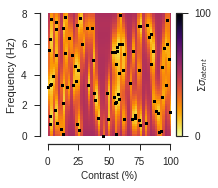

In [38]:
fig, ax = plt.subplots(1)

cax = ax.imshow(latent_uncertainty, origin = 'lower', cmap = 'inferno_r', extent = (0, 100, 0, 8), 
                aspect = 100 / 8, vmin = 0, vmax = 100)

ax.scatter(x_contrast, x_frequency, color = 'k', s = 5, marker = 'o', clip_on = False, label = 'Sampled')
# ax.scatter(peaks[:, 0], peaks[:, 1], color = 'k', s = 15, marker = 'x', clip_on = False, label = 'Proposed')

plt.xlim(0, 100)
plt.xticks(np.arange(0, 125, 25))
ax.set_xlabel('Contrast (%)', fontsize = 10)

plt.ylim(0, 8)
plt.yticks(np.arange(0, 10, 2), fontsize = 10)
ax.set_ylabel('Frequency (Hz)')

plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 8)

cbar = fig.colorbar(cax, ax = ax, ticks=[0, 100], 
                    fraction=0.046, pad=0.04)
cbar.set_label('$\Sigma \sigma_{latent}$', labelpad= -15, y=0.5, fontsize = 10)

# plt.legend(ncol = 2, bbox_to_anchor = (-0.1, 1.05, 1, 0), handletextpad = -0.25)

# plt.tight_layout()

fig.set_size_inches(2.4, 2.4)

plt.savefig(directories['figs'] + 'active/' + 'Parameter Space Control_{0}.svg'.format(n_trials), dpi = 600)

In [13]:
np.savetxt(directories['data'] + 'latent_uncertainty_control_{0}.csv'.format(n_trials), latent_uncertainty.flatten(), 
           fmt = '%3.2f', delimiter = ',', newline = '\n\n')

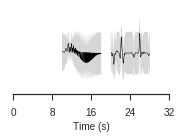

In [99]:
n_tpnts = 512

# Contrast Prediction

cont_tpnts = np.linspace(0, 8, n_tpnts) + 20
x_new_phase = ((4 * np.pi * np.linspace(0, 8, n_tpnts) )  % (2 * np.pi))[:, None]

X_predict = np.concatenate([
        np.cos(x_new_phase),
        np.sin(x_new_phase),
        8 * np.ones([1, n_tpnts]).flatten(order = 'f')[:, None],
        np.linspace(0, 100, n_tpnts).flatten(order = 'f')[:, None] 
], axis = 1)

cont_mu, cont_sig = m1.predict(X_predict, include_likelihood = False)

# Frequency Prediction

freq_tpnts = np.linspace(0, 8, n_tpnts) + 10
x_new_frequency = ((np.pi * np.linspace(0, 8, n_tpnts) ** 2) % (2 * np.pi))[:, None]

X_predict = np.concatenate([
        np.cos(x_new_frequency),
        np.sin(x_new_frequency),
        np.linspace(0, 8, n_tpnts).flatten(order = 'f')[:, None],
        100 * np.ones([1, n_tpnts]).flatten(order = 'f')[:, None] 
], axis = 1)

freq_mu, freq_sig = m1.predict(X_predict, include_likelihood = False)

fig, ax = plt.subplots(1)

ax.plot(cont_tpnts, cont_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(cont_mu, cont_sig, n_sigma = 3)
ax.fill_between(cont_tpnts, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.plot(freq_tpnts, freq_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(freq_mu, freq_sig, n_sigma = 3)
ax.fill_between(freq_tpnts, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
ax.set_ylim(-3, 3)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2.8, 1.5)

plt.savefig(directories['figs'] + 'active/' + 'sine_ctrl.svg', dpi = 300)